# 1-D Dirichlet boundary conditions (Unit 1.3)

This section shows how to solve the Dirichlet problem
$$−\Delta u=f \text{ in } \Omega$$

with a nonhomogeneous Dirichlet boundary condition $u|_{\Gamma_D}=g$ on a boundary part $\Gamma_D$, (and no constraint on any other boundary parts).
#### The extension technique

We use the standard technique of reducing a problem with essential non-homogeneous boundary conditions to one with homogeneous boundary condition using an extension. The solution $u$ in $H^1$ satisfies
$$u|_{\Gamma_D}=g$$ and 
$$\int_\Omega \nabla u \cdot \nabla v_0 = \int_\Omega f v_0$$ 
for all $v_0 \in H_{0,D}^1=\lbrace v \in H^1:v_|\Gamma_D=0\rbrace.$

Split the solution
$$u=u_0+u_D$$
where $u_D$ is an extension of $g$ into $\Omega$. Then we only need to find $u_0$ in $H_{0,D}^1$ satisfying the homogeneous Dirichlet problem
$$\int_\Omega \nabla u_0 \cdot \nabla v_0 = \int_\Omega f v_0 - \int_\Omega \nabla u_D \cdot \nabla v_0$$
for all $v_0$ in $H_{0,D}^1$.

#### Issues to consider

- How to define an extension $u_D$ in the finite element space?
- How to form and solve the system for $u_0$?


In [1]:
import netgen.gui
%gui tk
from ngsolve import *
import ngsolve.internal as ngint
ngint.viewoptions.drawedges = 1
from mesh_util import uniform_1d_mesh
from matplotlib import pyplot as plt
from numpy import linspace

In [2]:
mesh = Mesh(uniform_1d_mesh())
mesh.GetBoundaries()

('left', 'right')

The unit_square has its boundaries marked as left and right. Suppose we want non-homogeneous Dirichlet boundary conditions on
$$ \Gamma_{right}.$$
Then, we set the space as follows:

In [3]:
fes = H1(mesh, order=2, dirichlet='right')

In [4]:
fs2 = H1(mesh, order=2)

In [5]:
fes.ndof, fs2.ndof

(21, 21)

Thus, the dirichlet flag did not change ndof. In NGSolve the unknowns are split into two groups:

- dirichlet dofs (or constrained dofs),
- free dofs.

The facility FreeDofs gives a BitArray such that FreeDofs $[\text{dof}]$ is True iff dof is a free degree of freedom.


In [6]:
print("fs2 free dofs: ", fs2.FreeDofs())
print("fes free dofs: ", fes.FreeDofs())

fs2 free dofs:  0: 111111111111111111111
fes free dofs:  0: 111111111101111111111



- The space fs2 without dirichlet flag has only free dofs (no dirichlet dofs).

- The other space fes has one dofs marked as not free. This is the dof that are located on the boundary region we marked as dirichlet.

### Forms and assembly

In NGSolve, bilinear and linear forms are defined independently of the dirichlet flags. Matrices and vectors are set up with respect to all unknowns (free or constrained) so they may be restricted to any group of unknowns later.



In [7]:
u = fes.TrialFunction()
v = fes.TestFunction()

a = BilinearForm(fes, symmetric=True)
a += SymbolicBFI(grad(u)*grad(v))
a.Assemble()


If $A$= a.mat is the matrix just assembled, then we want to solve for
$$ A(u_0+u_D)=f \rightarrow Au_0=f−Au_D$$
or
$$
\left(
\begin{array}[cc]
\ A_{FF} & A_{FD} \\
A_{DF} & A_{DD}
\end{array}
\right)
\left(
\begin{array}[c]
\ u_{0,F} \\
0
\end{array}
\right)
=
\left(
\begin{array}[c]
\ f_F \\
f_D
\end{array}
\right)
-
\left(
\begin{array}[cc]
\ A_{FF} & A_{FD} \\
A_{DF} & A_{DD}
\end{array}
\right)
\left(
\begin{array}[c]
\ u_{D,F} \\
u_{D,D}
\end{array}
\right)
$$

where we have block partitioned using free dofs (F) and dirichlet dofs (D) as if they were numbered consecutively (which is typically not true). The first row gives
$$A_{FF}u_{0,F}=f_F−[Au_D]_F.$$

Hence, we need to:

- Construct $u_D$ from $g$.
- Set up the right hand side from $f$ and $u_D$.
- Solve a linear system which involves only $A_{FF}$.
- Add solution: $u=u_0+u_D$.


### Extending the boundary values

Suppose we are given that
$$g=3 \text{ on }\Gamma_D.$$

In [8]:
g = CoefficientFunction(3)

We interpolate $g$ on the boundary of the domain and extend trivially to $\Omega$ as follows:

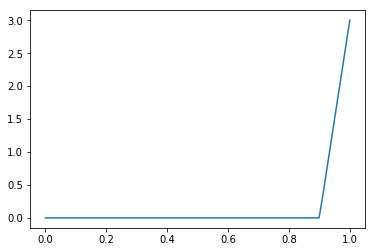

In [9]:
gfu = GridFunction(fes)
gfu.Set(g,BND)
Draw(gfu)
xs = linspace(0,1,100)
plt.plot(xs,[gfu(x) for x in xs])

In [10]:
print(a.mat)

Row 0:   0: 10
Row 1:   0: -10   1: 20
Row 2:   1: -10   2: 20
Row 3:   2: -10   3: 20
Row 4:   3: -10   4: 20
Row 5:   4: -10   5: 20
Row 6:   5: -10   6: 20
Row 7:   6: -10   7: 20
Row 8:   7: -10   8: 20
Row 9:   8: -10   9: 20
Row 10:   9: -10   10: 10
Row 11:   0: 0   1: 0   11: 0.833333
Row 12:   1: 0   2: 0   12: 0.833333
Row 13:   2: 0   3: 0   13: 0.833333
Row 14:   3: 0   4: 0   14: 0.833333
Row 15:   4: 0   5: 0   15: 0.833333
Row 16:   5: 0   6: 0   16: 0.833333
Row 17:   6: 0   7: 0   17: 0.833333
Row 18:   7: 0   8: 0   18: 0.833333
Row 19:   8: 0   9: 0   19: 0.833333
Row 20:   9: 0   10: 0   20: 0.833333




The keyword BND tells Set that $g$ need only be interpolated on those parts of the boundary that are marked dirichlet.
### Solve for the free dofs

We need to assemble the right hand side of $A_{FF}u_{0,F} = f_F−[Au_D]_F,$ namely
$$r=f−Au_D.$$

In [11]:
forcing = CoefficientFunction(1)
f = LinearForm(fes)
f += SymbolicLFI(forcing*v)
f.Assemble()

r = f.vec.CreateVector()
r.data = f.vec - a.mat * gfu.vec

The implementation of
$$
u=u_D + \left(
\begin{array}[cc]
\ A_{FF}^{−1} & 0 \\
\ 0 & 0
\end{array}
\right) r
$$
by sparse solvers is achieved by the following:

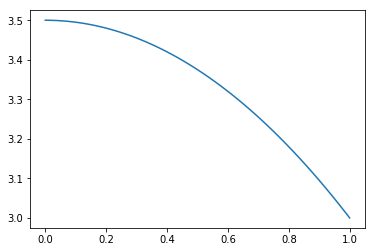

In [12]:
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r
Redraw()
xs = linspace(0,1,100)
plt.plot(xs,[gfu(x) for x in xs])

Using BVP

NGSolve also provides a BVP facility, within which the above steps are performed automatically. You provide $A$, $f$, a grid function gfu with the boundary condition, and a preconditioner. Then BVP solves the problem with non-homogeneous Dirichlet boundary condition and overwrites gfu with the solution.

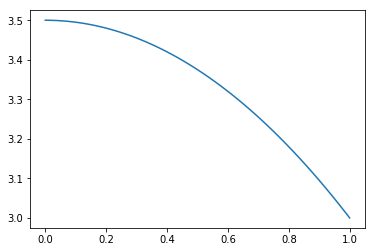

In [13]:
c = Preconditioner(a,"local")   #<- Jacobi preconditioner
#c = Preconditioner(a,"direct") #<- sparse direct solver
c.Update()
BVP(bf=a,lf=f,gf=gfu,pre=c).Do()
Redraw()
xs = linspace(0,1,100)
plt.plot(xs,[gfu(x) for x in xs])